# Introduction: Feature Selector Usage

In this notebook we will walk-through using the `FeatureSelector` class for selecting features to remove from a dataset. This class has five methods for finding features to remove: 

1. Find columns with a missing fraction greater than a specified threshold
2. Find features with only a single unique value
3. Find collinear features as identified by a correlation coefficient greater than a specified value
4. Find features with 0.0 importance from a gradient boosting machine
5. Find features that do not contribute to a specified cumulative feature importance from the gradient boosting machine

The FeatureSelector is a work in progress! Any contributions on GitHub are appreciated.

In [1]:
%load_ext autoreload
%autoreload 2
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt

import pandas as pd

## Example Dataset

This dataset was used as part of the [Home Credit Default Risk competition on Kaggle](https://www.kaggle.com/c/home-credit-default-risk/). It is intended for a supervised machine learning classification task where the objective is to predict if a client will default on a loan. The entire dataset can be downloaded [here] and we will work with a small sample of 10,000 rows. 

The feature selector was designed to be used for machine learning tasks, but can be applied to any dataset.\ The feature importance based methods do require a supervised machine learning problem.

In [2]:
train = pd.read_csv('data/fresh_train_206.csv')
train = train[train['state']==1]
train_labels = train['usd_pledged_real']
train_labels.head()

0    10.371176
2     9.331629
3     8.423322
5     8.574707
8     6.486161
Name: usd_pledged_real, dtype: float64

There are several categorical columns in the dataset. The `FeatureSelector` handles these using one-hot encoding when using the feature importance based methods.

In [3]:
train = train.drop(columns = ['state','usd_pledged_real'])

(array([2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 7.000e+00,
        1.000e+01, 1.600e+01, 1.000e+01, 8.000e+00, 1.900e+01, 2.200e+01,
        1.000e+01, 3.300e+01, 3.100e+01, 2.900e+01, 2.400e+01, 3.000e+01,
        8.600e+01, 7.200e+01, 8.100e+01, 1.060e+02, 1.180e+02, 1.490e+02,
        1.740e+02, 2.340e+02, 2.900e+02, 2.930e+02, 3.340e+02, 5.990e+02,
        5.890e+02, 5.400e+02, 6.750e+02, 7.460e+02, 9.360e+02, 9.050e+02,
        8.650e+02, 9.580e+02, 1.095e+03, 1.131e+03, 1.331e+03, 1.401e+03,
        1.427e+03, 1.411e+03, 1.261e+03, 1.887e+03, 1.434e+03, 1.227e+03,
        1.214e+03, 1.316e+03, 1.260e+03, 1.013e+03, 1.001e+03, 8.590e+02,
        8.140e+02, 6.180e+02, 7.450e+02, 6.240e+02, 4.850e+02, 3.950e+02,
        3.860e+02, 3.420e+02, 2.550e+02, 2.370e+02, 2.020e+02, 1.890e+02,
        1.820e+02, 1.180e+02, 1.120e+02, 1.100e+02, 8.100e+01, 5.400e+01,
        5.500e+01, 4.900e+01, 4.800e+0

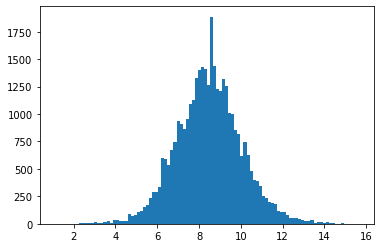

In [4]:
plt.hist(train_labels,bins=100)

# Implementation

The `FeatureSelector` has five functions for identifying columns to remove:

* `identify_missing`
* `identify_single_unique`
* `identify_collinear`
* `identify_zero_importance` 
* `identify_low_importance`

These methods find the features to drop according to specified criteria. The identified features are stored in the `ops` attribute (a Python dictionary) of the `FeatureSelector`. We can remove the identified features manually or use the `remove` function in the  `FeatureSelector` for actually removing the features. 

### Create the Instance

The `FeatureSelector` only requires a dataset with observations in the rows and features in the columns (standard structured data). We are working with a classifified machine learning problem so we also pass in training labels.

In [5]:
fs = FeatureSelector(data = train, labels = train_labels)

# 3. Collinear (highly correlated) Features

This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a `correlation_threshold`. 

This method is based on code found at https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

For each pair, the feature that will be removed is the one that comes last in terms of the column ordering in the dataframe. (This method does not one-hot encode the data beforehand unless `one_hot=True`. Therefore correlations are only calculated between numeric columns)

In [6]:
fs.identify_collinear(correlation_threshold=0.9)

3 features with a correlation magnitude greater than 0.90.



In [7]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['aboutNumSents', 'risksNumSents', 'cTotal']

We can view a heatmap of the correlations above the threhold. The features which will be dropped are on the x-axis. 

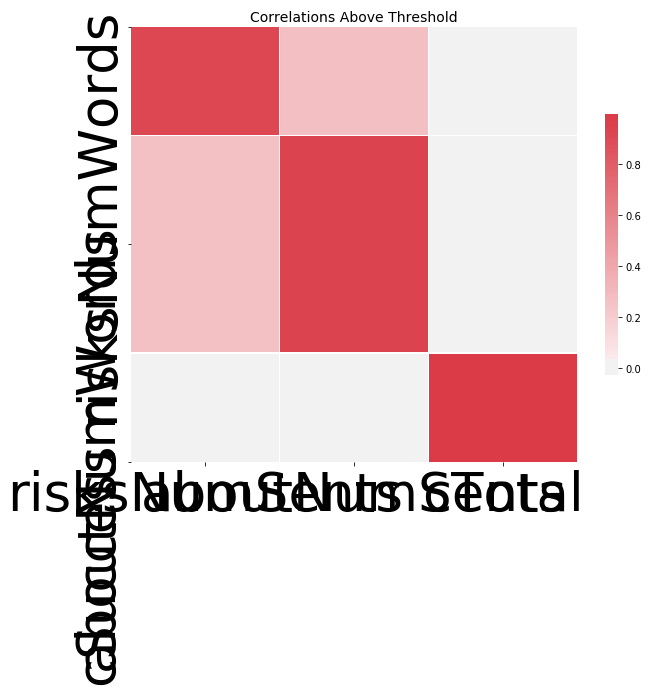

In [8]:
fs.plot_collinear()

To plot all of the correlations in the data, we can pass in `plot_all = True` to the `plot_collinear` function. 

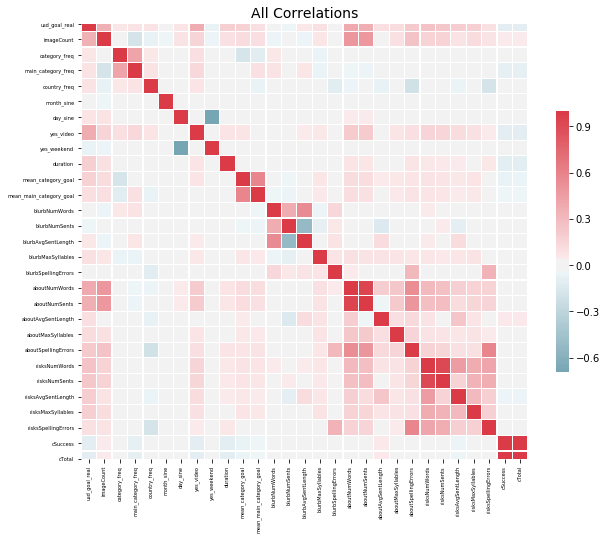

In [9]:
fs.plot_collinear(plot_all=True)

1 features with a correlation magnitude greater than 0.99.



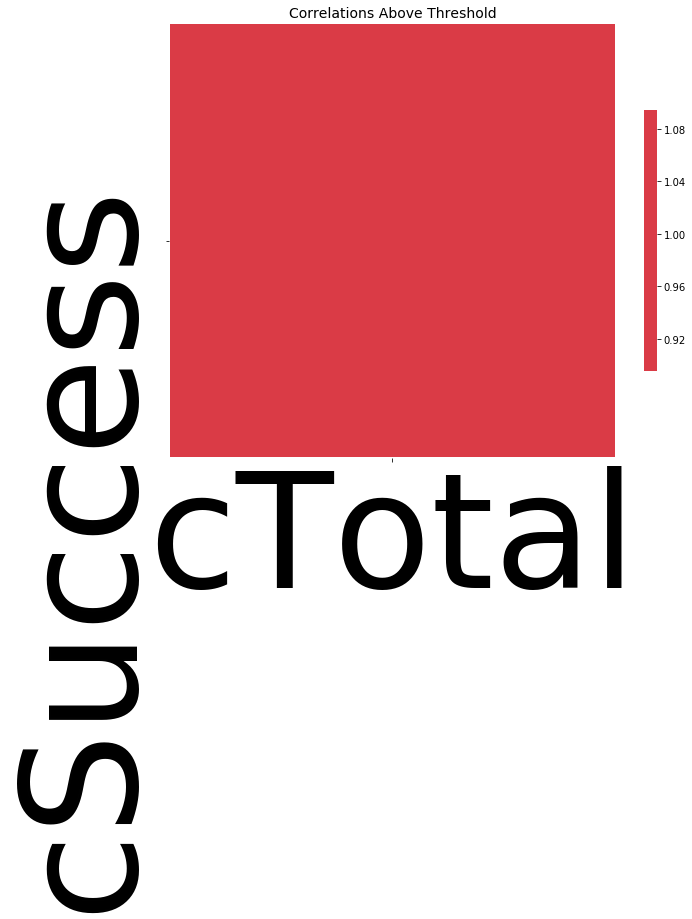

In [10]:
fs.identify_collinear(correlation_threshold=0.99)
fs.plot_collinear()

To view the details of the corelations above the threshold, we access the `record_collinear` attribute which is a dataframe. The `drop_feature` will be removed and for each feature that will be removed, there may be several correlations it has with the `corr_feature` that are above the `correlation_threshold`.

In [11]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,cTotal,cSuccess,0.994841


# 4. Zero Importance Features

This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. The method works by finding feature importances using a gradient boosting machine implemented in the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html). 

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train. The following parameters can be passed to the `identify_zero_importance` method:

* `task`: either `classification` or `regression`. The metric and labels must match with the task
* `eval_metric`: the metric used for early stopping (for example `auc` for classification or `l2` for regression). To see a list of available metrics, refer to the [LightGBM docs](http://testlightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters)
* `n_iterations`: number of training runs. The feature importances are averaged over the training runs (default = 10)
* `early_stopping`: whether to use early stopping when training the model (default = True). [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) stops training estimators (decision trees) when the performance on a validation set no longer decreases for a specified number of estimators (100 by default in this implementation). Early stopping is a form of regularization used to prevent overfitting to training data

The data is first one-hot encoded for use in the model. This means that some of the zero importance features may be created from one-hot encoding. To view the one-hot encoded columns, we can access the `one_hot_features` of the `FeatureSelector`.

__Note of caution__: in contrast to the other methods, the feature imporances from a model are non-deterministic (have a little randomness). The results of running this method can change each time it is run. 

In [12]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'l2', n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model


1 features with zero importance after one-hot encoding.



Running the gradient boosting model requires one hot encoding the features. These features are saved in the `one_hot_features` attribute of the `FeatureSelector`. The original features are saved in the `base_features`.

In [13]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 29 original features
There are 0 one-hot features


The `data` attribute of the `FeatureSelector` holds the original dataframe. After one-hot encoding, the `data_all` attribute holds the original data plus the one-hot encoded features.

In [14]:
fs.data_all.head(10)

,usd_goal_real,imageCount,category_freq,main_category_freq,country_freq,month_sine,day_sine,yes_video,yes_weekend,duration,...,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksNumSents,risksAvgSentLength,risksMaxSyllables,risksSpellingErrors,cSuccess,cTotal
0,9.903538,7,0.021760,0.151582,0.730588,1.224647e-16,0.781831,1,0,34,...,21.571429,6,14,156,8,17.333333,5,0,0,0
2,9.325317,10,0.012296,0.077590,0.047175,8.660254e-01,-0.433884,1,0,39,...,23.384615,4,5,272,14,18.133333,4,5,0,0
3,8.412055,32,0.008149,0.048866,0.730588,1.224647e-16,0.000000,1,0,29,...,16.382979,5,9,51,2,17.000000,3,1,0,0
5,8.343078,6,0.014275,0.086317,0.730588,-8.660254e-01,0.781831,1,0,19,...,24.111111,5,13,115,5,19.166667,4,4,0,0
8,5.707110,8,0.005577,0.035356,0.730588,-8.660254e-01,-0.433884,0,0,19,...,22.333333,6,4,87,4,17.400000,4,1,1,1
9,5.698803,10,0.013871,0.143130,0.114246,5.000000e-01,0.000000,1,0,59,...,25.758621,5,22,247,10,22.454545,5,1,0,0
12,9.210440,39,0.013394,0.143130,0.730588,5.000000e-01,0.974928,1,0,27,...,19.027778,5,37,103,7,12.875000,4,2,0,0
13,6.311735,6,0.007065,0.034879,0.730588,1.224647e-16,0.000000,0,0,39,...,20.166667,5,1,34,1,17.000000,3,0,0,0
14,6.803505,7,0.013871,0.143130,0.730588,-1.000000e+00,0.000000,1,0,29,...,16.300000,4,8,88,7,11.000000,5,2,0,0
17,10.308986,82,0.020098,0.053605,0.730588,-8.660254e-01,0.974928,1,0,29,...,19.215385,8,49,103,5,17.166667,5,2,0,0


There are a number of methods we can use to inspect the results of the feature importances. First we can access the list of features with zero importance. 

In [15]:
zero_importance_features = fs.ops['zero_importance']
# zero_importance_features[10:15]

### Plot Feature Importances

The feature importance plot using `plot_feature_importances` will show us the `plot_n` most important features (on a normalized scale where the features sum to 1). It also shows us the cumulative feature importance versus the number of features. 

When we plot the feature importances, we can pass in a `threshold` which identifies the number of features required to reach a specified cumulative feature importance. For example, `threshold = 0.99` will tell us the number of features needed to account for 99% of the total importance.

In [16]:
trainDrop = train.drop(['cTotal', 'aboutNumSents', 'risksNumSents'],axis=1)
fsDrop = FeatureSelector(data = trainDrop, labels = train_labels)
fsDrop.identify_zero_importance(task = 'regression', eval_metric = 'l2', n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model


1 features with zero importance after one-hot encoding.



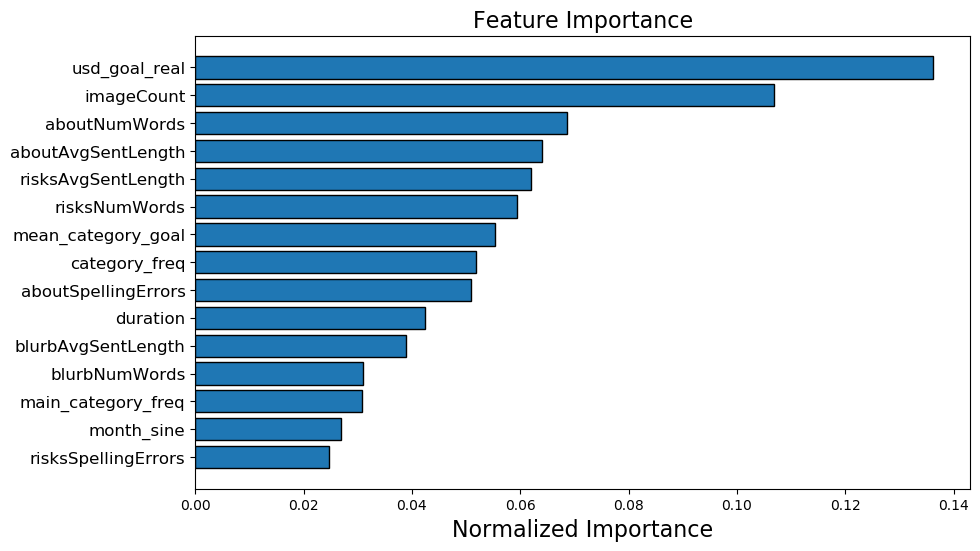

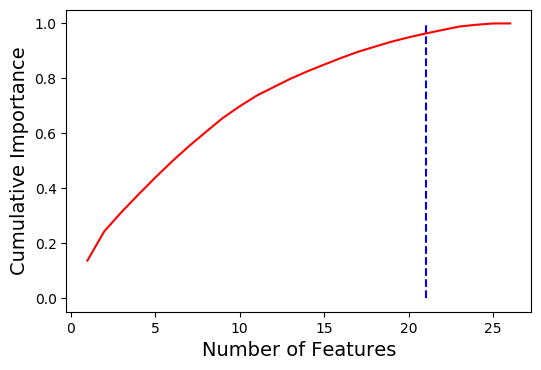

21 features required for 0.95 of cumulative importance


In [17]:
# fs.plot_feature_importances(threshold = 0.95, plot_n = 20)
fsDrop.plot_feature_importances(threshold = 0.95, plot_n = 15)

All of the feature importances are accessible in the `feature_importances` attribute of the `FeatureSelector`

In [18]:
# fs.feature_importances.head(10)

We could use these results to select only the 'n' most important features. For example, if we want the top 100 most importance, we could do the following.

In [19]:
one_hundred_features = list(fs.feature_importances.loc[:99, 'feature'])
len(one_hundred_features)

29

# 5. Low Importance Features

This method builds off the feature importances from the gradient boosting machine (`identify_zero_importance` must be run first) by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, if we pass in 0.99, this will find the lowest important features that are not needed to reach 99% of the total feature importance. 

When using this method, we must have already run `identify_zero_importance` and need to pass in a `cumulative_importance` that accounts for that fraction of total feature importance.

__Note of caution__: this method builds on the gradient boosting model features importances and again is non-deterministic. I advise running these two methods several times with varying parameters and testing each resulting set of features rather than picking one number and sticking to it.

In [20]:
fsDrop.identify_low_importance(cumulative_importance = 0.95)

20 features required for cumulative importance of 0.95 after one hot encoding.
6 features do not contribute to cumulative importance of 0.95.



The low importance features to remove are those that do not contribute to the specified cumulative importance. These are also available in the `ops` dictionary. 

In [21]:
low_importance_features = fsDrop.ops['low_importance']
low_importance_features

['blurbSpellingErrors',
 'blurbMaxSyllables',
 'risksMaxSyllables',
 'blurbNumSents',
 'yes_video',
 'yes_weekend']

# Removing Features

Once we have identified the features to remove, we have a number of ways to drop the features. We can access any of the feature lists in the `removal_ops` dictionary and remove the columns manually. We also can use the `remove` method, passing in the methods that identified the features we want to remove.

This method returns the resulting data which we can then use for machine learning. The original data will still be accessible in the `data` attribute of the Feature Selector.

__Be careful__ of the methods used for removing features! It's a good idea to inspect the features that will be removed before using the `remove` function. 

In [22]:
train_no_missing = fs.remove(methods = ['missing'])

NotImplementedError: missing method has not been run

In [ ]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])

To remove the features from all of the methods, pass in `method='all'`. Before we do this, we can check how many features will be removed using `check_removal`. This returns a list of all the features that have been idenfitied for removal. 

In [ ]:
all_to_remove = fs.check_removal()
all_to_remove[10:25]

Now we can remove all of the features idenfitied.

In [ ]:
train_removed = fs.remove(methods = 'all')

### Handling One-Hot Features

If we look at the dataframe that is returned, we may notice several new columns that were not in the original data. These are created when the data is one-hot encoded for machine learning. To remove all the one-hot features, we can pass in `keep_one_hot = False` to the `remove` method. 

In [ ]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

In [ ]:
print('Original Number of Features', train.shape[1])
print('Final Number of Features: ', train_removed_all.shape[1])

# Alternative Option for Using all Methods

If we don't want to run the identification methods one at a time, we can use `identify_all` to run all the methods in one call. For this function, we need to pass in a dictionary of parameters to use for each individual identification method. 

The following code accomplishes the above steps in one call.

In [ ]:
fs = FeatureSelector(data = train, labels = train_labels)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

In [ ]:
train_removed_all_once = fs.remove(methods = 'all', keep_one_hot = True)

In [ ]:
fs.feature_importances.head()

There is a slight discrepancy between the number of features removed because the feature importances have changed. The number of features identified for removal by the `missing`, `single_unique`, and `collinear` will stay the same because they are deterministic, but the number of features from `zero_importance` and `low_importance` may vary due to training a model multiple times. 

# Conclusions

This notebook showed how to use the `FeatureSelector` class for removing features from a dataset. There are a few important notes from this implementation:

* Feature importances will change on multiple runs of the machine learning model
* Decide whether or not to keep the extra features created from one-hot encoding
* Try out several different values for the various parameters to decide which ones work best for a machine learning task
* The output of missing, single unique, and collinear will stay the same for the identical parameters
* Feature selection is a critical step of a machine learning workflow that may require several iterations to optimize

I appreciate any comments, feedback, or help on this project.

Will